In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from shutil import copyfile

**Mount google drive that containes training data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#you should change this variable to your project directory
project_directory = '/content/drive/Shareddrives/PFA 1A/'
images_directory = project_directory+'/images'
print(len(os.listdir(project_directory)))

19


**Load pre-trained model and make its layers trainable**

In [ ]:
from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(include_top=False,weights="imagenet",input_shape=(256,256,3),input_tensor=None)

for layer in pretrained_model.layers :
  layer.trainable=True

# pretrained_model.summary()


94773248/94765736 [==============================] - 1s 0us/step


**Add your output layers**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model


x= pretrained_model.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (6, activation='softmax')(x)  

model = Model(pretrained_model.input,x)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Create your data generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.5,
    zoom_range = 0.5,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    images_directory+'/training',
    target_size = (256,256),
    batch_size = 5,
    class_mode = 'categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    images_directory+'/training',
    target_size = (256,256),
    batch_size = 5,
    class_mode = 'categorical',
    subset='validation'
)

Found 446 images belonging to 6 classes.
Found 108 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# When to save the model
checkpointer = ModelCheckpoint(filepath=project_directory+'/model.weights.best.hdf5', verbose=0, 
                               save_best_only=True)

# Reduce learning rate when loss doesn't improve after n epochs
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=0)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//validation_generator.batch_size,
    verbose = 2,
    callbacks=[scheduler,early_stopper]
)

Epoch 1/25
89/89 - 69s - loss: 1.0554 - accuracy: 0.8005 - val_loss: 14.5113 - val_accuracy: 0.0762
Epoch 2/25
89/89 - 66s - loss: 0.5141 - accuracy: 0.8821 - val_loss: 24.3332 - val_accuracy: 0.1524
Epoch 3/25
89/89 - 66s - loss: 0.6652 - accuracy: 0.8526 - val_loss: 34.7059 - val_accuracy: 0.2476
Epoch 4/25
89/89 - 67s - loss: 0.4367 - accuracy: 0.8912 - val_loss: 20.9533 - val_accuracy: 0.2667
Epoch 5/25
89/89 - 66s - loss: 0.4137 - accuracy: 0.8980 - val_loss: 33.2976 - val_accuracy: 0.2571
Epoch 6/25
89/89 - 66s - loss: 0.3557 - accuracy: 0.9229 - val_loss: 9.0909 - val_accuracy: 0.3429
Epoch 7/25
89/89 - 65s - loss: 0.2634 - accuracy: 0.9274 - val_loss: 2.4586 - val_accuracy: 0.4762
Epoch 8/25
89/89 - 66s - loss: 0.2389 - accuracy: 0.9388 - val_loss: 2.2615 - val_accuracy: 0.5333
Epoch 9/25
89/89 - 66s - loss: 0.2912 - accuracy: 0.9342 - val_loss: 1.0660 - val_accuracy: 0.7429
Epoch 10/25
89/89 - 66s - loss: 0.2905 - accuracy: 0.9524 - val_loss: 1.5677 - val_accuracy: 0.9048
Epoc

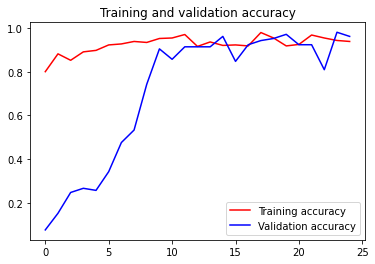

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

**save model so that you load it later**

**Load best weights**

In [ ]:
model.save(project_directory+'/models/model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.load_weights(project_directory+'/model.weights.best.hdf5')

#Test your model with images in a test folder

In [ ]:
import numpy as np
from keras.preprocessing import image
 
 
# you should change this based on what input size the model trained on 
input_size = (256,256)

test_images_directory = images_directory+"/new test samples/200 dh/" 
 
test_list = os.listdir(test_images_directory)

classes = ["10 dh","100 dh","20 dh","200 dh","5 dh","50 dh"]


 
for fn in test_list :
 
  # predicting images
 
  path = test_images_directory + fn
  
  # copy it there
 
  img = image.load_img(path, target_size = input_size) 
  
  x = image.img_to_array(img)/255
    
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  
  proba = model.predict(images, batch_size=10)
  predict_index = proba[0].argmax()
  max_proba = max(proba[0])
  if max_proba < 0.9:
    predict = "none"
  else:
    predict = classes[predict_index]
  print(max_proba)
  print(fn + " is a " + predict)

0.8816147
16228941143082857757627906916181.jpg is a none
0.8421239
16228941958106279444852058058706.jpg is a none
0.99999833
1622894249298233023513672530293.jpg is a 200 dh
0.9850086
16228945104341390822418175998675.jpg is a 200 dh
0.9998778
16228945467832437052976403858148.jpg is a 200 dh
0.9999596
1622894607025539127759647648579.jpg is a 200 dh
0.9999474
16228946559981839704141661360800.jpg is a 200 dh
0.99981385
16228957698974809675407919040674.jpg is a 200 dh
0.98712885
16228961351511612508241591692635.jpg is a 200 dh
